*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass

import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, Embedding
print(tf.__version__)

You should consider upgrading via the 'c:\users\tizbi\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
C:\Users\tizbi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tizbi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\tizbi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


You should consider upgrading via the 'c:\users\tizbi\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


2.8.0-dev20211003


In [2]:
# get data files

train_url = 'https://cdn.freecodecamp.org/project-data/sms/train-data.tsv'
valid_url =  'https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv'

train = requests.get(train_url).content
valid = requests.get(valid_url).content

train_df = pd.read_table(io.StringIO(train.decode('utf-8')),header=None,names =['label','message'])
test_df = pd.read_table(io.StringIO(valid.decode('utf-8')),header=None,names =['label','message'])

Load Data

In [3]:
train_df.head()

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [4]:
test_df.head()

,label,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [5]:
train_df.isnull().sum()

label      0
message    0
dtype: int64

In [6]:
test_df.isnull().sum()

label      0
message    0
dtype: int64

convert label to numerical variable

In [7]:
train_df['label']= pd.get_dummies(train_df['label'])
test_df['label'] = pd.get_dummies(test_df['label'])


In [8]:
train_df.tail()

,label,message
4174,1,just woke up. yeesh its late. but i didn't fal...
4175,1,what do u reckon as need 2 arrange transport i...
4176,0,free entry into our £250 weekly competition ju...
4177,0,-pls stop bootydelious (32/f) is inviting you ...
4178,1,tell my bad character which u dnt lik in me. ...


Put data in appropriate structure

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_df["message"].values, train_df["label"].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df["message"].values, test_df["label"].values))

print(train_dataset.element_spec,test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None)) (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))


In [10]:
# prefetching / buffering of the data for best performance on GPU
train_dataset = train_dataset.shuffle(buffer_size =100).batch(batch_size = 30).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size = 30).prefetch(tf.data.AUTOTUNE)

Text Preprocessing : TextVectorization

In [11]:
# constants.
max_features = 1000
embedding_dim = 50
sequence_length = 100

#define vetorization layer
vectorize_layer = TextVectorization(
max_tokens=max_features,
output_mode='int',
output_sequence_length=sequence_length)

text_ds = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)


Build Model

In [12]:
model = tf.keras.models.Sequential([
  vectorize_layer,
  tf.keras.Input(shape=(1,), dtype=tf.string),
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

In [13]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 50)           50000     
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         183296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                        

Fit model and plot history

In [14]:
history = model.fit(train_dataset,
                    epochs=20,
                    verbose=False,
                    validation_data=test_dataset,
                    validation_steps=20,
                    batch_size=10)


In [15]:
loss, accuracy = model.evaluate(train_dataset, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_dataset, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9988
Testing Accuracy:  0.9828


plot train test error

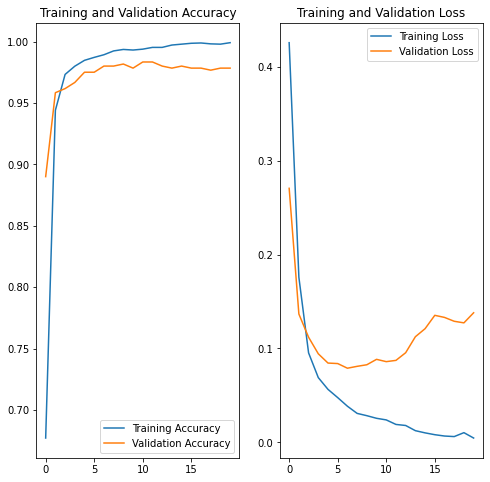

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:

def predict_message(pred_text):
    result = model.predict([pred_text])
    predict = result[0][0]
    return [predict, "ham" if predict < 0.5 else "spam"]

pred_text = "wow, is your arm alright. that happened to me one time too"

prediction = predict_message(pred_text)
print(prediction)

[10.375291, 'spam']


In [18]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You haven't passed yet. Keep trying.


In [19]:
#save model
model.save("classifier_model")

INFO:tensorflow:Assets written to: classifier_model\assets


INFO:tensorflow:Assets written to: classifier_model\assets
